In [314]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import numpy as np
import copy

In [315]:
## TODO: convert date range to datetime column
## TODO: time series prediction for next X days (say next month)

In [316]:
obsidian_flames = pd.read_csv('Obsidian_Flames.csv', index_col = 'Unnamed: 0')
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,['Holofoil Market Price: '],7/18 to 7/20,$0.00
1,Absol ex - 135/197,['Holofoil Market Price: '],7/21 to 7/23,$0.00
2,Absol ex - 135/197,['Holofoil Market Price: '],7/24 to 7/26,$0.00
3,Absol ex - 135/197,['Holofoil Market Price: '],7/27 to 7/29,$0.00
4,Absol ex - 135/197,['Holofoil Market Price: '],7/30 to 8/1,$4.87
...,...,...,...,...
12925,Zigzagoon,['Reverse Holofoil Market Price: '],10/7 to 10/9,$0.06
12926,Zigzagoon,[' Market Price: '],10/10 to 10/12,$0.03
12927,Zigzagoon,['Reverse Holofoil Market Price: '],10/10 to 10/12,$0.06
12928,Zigzagoon,[' Market Price: '],10/13 to 10/15,$0.03


In [317]:
obsidian_flames['Foil'].unique()

array(["['Holofoil Market Price: ']", "[' Market Price: ']",
       "['Reverse Holofoil Market Price: ']"], dtype=object)

In [318]:
obsidian_flames.replace({'Foil' : { "[' Market Price: ']" : "Normal",
                               "['Reverse Holofoil Market Price: ']" : "Reverse Holofoil", 
                               "['Holofoil Market Price: ']" : "Holofoil"}}, inplace=True)
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/18 to 7/20,$0.00
1,Absol ex - 135/197,Holofoil,7/21 to 7/23,$0.00
2,Absol ex - 135/197,Holofoil,7/24 to 7/26,$0.00
3,Absol ex - 135/197,Holofoil,7/27 to 7/29,$0.00
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,$0.06
12926,Zigzagoon,Normal,10/10 to 10/12,$0.03
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,$0.06
12928,Zigzagoon,Normal,10/13 to 10/15,$0.03


In [319]:
sum(obsidian_flames['Market Price'] == "$0.00") / len(obsidian_flames['Market Price'] == "$0.00")
# Just 20% of the dataset has $0.00 market price

0.20471771075019335

In [320]:
of_cleaned = obsidian_flames[obsidian_flames['Market Price'] != '$0.00']
of_cleaned

,Product,Foil,Date Range,Market Price
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
5,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
6,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
7,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
8,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,$0.06
12926,Zigzagoon,Normal,10/10 to 10/12,$0.03
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,$0.06
12928,Zigzagoon,Normal,10/13 to 10/15,$0.03


In [321]:
of_cleaned = of_cleaned.sort_values(by=['Product', 'Foil'])
of_cleaned

,Product,Foil,Date Range,Market Price
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
5,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
6,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
7,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
8,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/1 to 10/3,$0.06
12923,Zigzagoon,Reverse Holofoil,10/4 to 10/6,$0.06
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,$0.06
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,$0.06


In [322]:
of_cleaned['Market Price'] = of_cleaned['Market Price'].replace({'\$':''}, regex = True)
of_cleaned['Market Price'] = of_cleaned['Market Price'].astype(float)
of_cleaned

,Product,Foil,Date Range,Market Price
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
5,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
6,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
7,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
8,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06
12923,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06


In [323]:
of_cleaned = of_cleaned.reset_index(drop=True)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
10278,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06
10279,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06
10280,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06
10281,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06


In [324]:
match_adj_product = [of_cleaned['Product'][i] == of_cleaned['Product'][i+1] for i in range(len(of_cleaned['Product'])-1)]
match_adj_foil = [of_cleaned['Foil'][i] == of_cleaned['Foil'][i+1] for i in range(len(of_cleaned['Foil'])-1)]
adj_match = [match_adj_product[i] and match_adj_foil[i] for i in range(len(match_adj_product))]
adj_mismatch = [not i for i in adj_match]
first_entries = adj_mismatch.copy()
first_entries.insert(0, True)
last_entries = adj_mismatch.copy()
last_entries.append(True)
first_market_price = of_cleaned[first_entries]['Market Price']
latest_market_price = of_cleaned[last_entries]['Market Price']
first_market_price = first_market_price.astype(float)
latest_market_price = latest_market_price.astype(float)
first_market_price = first_market_price.reset_index(drop=True)
latest_market_price = latest_market_price.reset_index(drop=True)

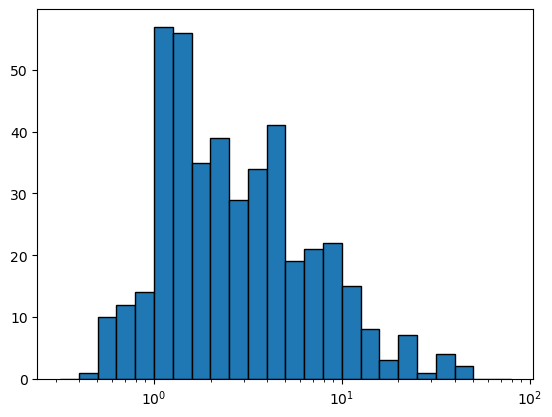

In [325]:
import matplotlib.pyplot as plt
initial_price_factor = [first_market_price[i]/latest_market_price[i] for i in range(len(latest_market_price))]
bins = 10**(.1*np.arange(-5,20))
plt.hist(initial_price_factor, bins=bins, edgecolor='black')
plt.xscale("log")
# seems that initial market prices are often several times higher than the price it settles at

In [326]:
sum([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))]) / len([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))])
# 54% of the initial prices are more than double the latest price in the dataset

0.541860465116279

In [327]:
def past_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        # whether product matches the product from the previous line
        match_prev_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        # whether foil matches the foil from the previous line
        match_prev_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the prev market price from the previous row
        if n == 0:
            prev_market_price = dataset['Market Price'][:-1]
        # otherwise take the latest next market price from the next row
        else:
            prev_market_price = dataset[f'Previous Market Price_{n}'][:-1]
            
        dataset = dataset[1:]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Previous Market Price_{n+1}'] = prev_market_price
        prev_match = [match_prev_product[i] and match_prev_foil[i] for i in range(len(match_prev_product))]
        dataset = dataset[prev_match]
        dataset = dataset.reset_index(drop=True)
    return dataset
        
        

In [328]:
def future_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        match_next_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        match_next_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the next market price from the next row
        if n == 0:
            next_market_price = dataset['Market Price'][1:]
        # otherwise take the latest next market price from the next row
        else:
            next_market_price = dataset[f'Next Market Price_{n}'][1:]
                    
        next_market_price = next_market_price.reset_index(drop=True)
        dataset = dataset[:-1]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Next Market Price_{n+1}'] = next_market_price
        next_match = [match_next_product[i] and match_next_foil[i] for i in range(len(match_next_product))]
        dataset = dataset[next_match]
        dataset = dataset.reset_index(drop=True)
    return dataset

In [329]:
past_prices(2, of_cleaned)
# looks pretty good

,Product,Foil,Date Range,Market Price,Previous Market Price_1,Previous Market Price_2
0,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.86,0.80
...,...,...,...,...,...,...
9418,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06,0.06,0.07
9419,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06,0.06,0.06
9420,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06,0.06,0.06
9421,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06,0.06,0.06


In [330]:
future_prices(2, of_cleaned)

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87,4.74,4.74
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74,4.74,2.04
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,2.04,0.80
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,0.80,0.86
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,0.86,0.81
...,...,...,...,...,...,...
9418,Zigzagoon,Reverse Holofoil,9/25 to 9/27,0.07,0.06,0.06
9419,Zigzagoon,Reverse Holofoil,9/28 to 9/30,0.06,0.06,0.06
9420,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06,0.06,0.06
9421,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06,0.06,0.06


In [331]:
# gets the next month of market prices
of_future_prices = future_prices(10, of_cleaned)
# obtains the last 15 days worth of prices
of_past_future_prices = past_prices(5, of_future_prices)
of_past_future_prices

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
0,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.80,2.04,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
3836,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07
3837,Zigzagoon,Reverse Holofoil,9/7 to 9/9,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.11,0.10,0.08,0.07,0.07
3838,Zigzagoon,Reverse Holofoil,9/10 to 9/12,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.10,0.11,0.10,0.08,0.07


# Data Split

In [332]:
of_past_future_prices['Date Range'].unique()

array(['8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31', '9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15', '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13'], dtype=object)

In [333]:
# test set will contain everything from September 25th on
test = of_past_future_prices.loc[of_cleaned['Date Range'].isin(['9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15'])]
train = of_past_future_prices.loc[of_cleaned['Date Range'].isin([ '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13', 
       '8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31'])]
test

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
11,Absol ex - 214/197,Holofoil,8/20 to 8/22,1.82,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.81,1.92,1.65,3.37,6.12
12,Absol ex - 214/197,Holofoil,8/23 to 8/25,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.82,1.81,1.92,1.65,3.37
13,Absol ex - 214/197,Holofoil,8/26 to 8/28,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.52,1.80,1.82,1.81,1.92,1.65
14,Absol ex - 214/197,Holofoil,8/29 to 8/31,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.52,1.73,1.50,1.80,1.82,1.81,1.92
15,Absol ex - 214/197,Holofoil,9/1 to 9/3,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.52,1.73,1.68,1.58,1.50,1.80,1.82,1.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,Zigzagoon,Reverse Holofoil,8/26 to 8/28,0.07,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.07,0.07,0.07,0.08,0.07
3834,Zigzagoon,Reverse Holofoil,8/29 to 8/31,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.07,0.07,0.07,0.07,0.08
3835,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
3836,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07


In [334]:
train

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
5,Absol ex - 135/197,Holofoil,8/29 to 8/31,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,1.16,0.93,0.92,0.81,0.81,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3828,Zigzagoon,Normal,9/4 to 9/6,0.04,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.04,0.05,0.06,0.06
3829,Zigzagoon,Normal,9/7 to 9/9,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.04,0.03,0.04,0.05,0.06
3830,Zigzagoon,Normal,9/10 to 9/12,0.04,0.04,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.03,0.04,0.05
3831,Zigzagoon,Normal,9/13 to 9/15,0.04,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04,0.03,0.04


In [335]:
of_cleaned.iloc[5884]

Product         Obsidian Flames 3 Pack Blister [Eevee]
Foil                                            Normal
Date Range                                10/1 to 10/3
Market Price                                     15.01
Name: 5884, dtype: object

In [336]:
# removed 'Product' from X_test and X_train since some of the products between train and test don't match
X_test = test[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_test = test['Next Market Price_10'].astype(float)
X_train = train[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_train = train['Next Market Price_10'].astype(float)

In [337]:
X_test = pd.get_dummies(X_test, columns = ['Foil'])
X_train = pd.get_dummies(X_train, columns = ['Foil'])

# Linear Regression

In [338]:
classifier = LinearRegression()
classifier.fit(X_train, y_train)

LinearRegression()

In [339]:
coefficients = pd.DataFrame(zip(X_train.columns, classifier.coef_))
coefficients

,0,1
0,Previous Market Price_1,-0.572172
1,Previous Market Price_2,0.270944
2,Previous Market Price_3,-0.032726
3,Previous Market Price_4,0.005570
4,Previous Market Price_5,0.078941
5,Market Price,1.195024
6,Foil_Holofoil,-0.102611
7,Foil_Normal,-0.123918
8,Foil_Reverse Holofoil,0.226529


In [340]:
y_pred = classifier.predict(X_test)

In [341]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [342]:
regression_results(y_test, y_pred)
# over 98% of variance explained which makes sense given that it has access to previous values

explained_variance:  0.9883
r2:  0.9883
MAE:  0.57
MSE:  7.1737
RMSE:  2.6784


# LSTM

In [343]:
X_train = train[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_train = row_list
X_test = test[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_test = row_list
# y_train = train[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_train = row_list
# y_test = test[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_test = row_list

In [344]:
X_train['Market Price']

1       0.81
2       0.81
3       0.92
4       0.93
5       1.01
        ... 
3828    0.04
3829    0.04
3830    0.04
3831    0.04
3832    0.07
Name: Market Price, Length: 1404, dtype: float64

In [345]:
# need a many to many lstm
# https://github.com/keras-team/keras/issues/6063
from keras import Sequential
from keras.layers import LSTM, Dense, TimeDistributed
model = Sequential()  
model.add(LSTM(32, input_dim=1, return_sequences=False))
model.add(Dense(1, activation='linear'))
# model.add(Activation('linear'))   
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])  

In [346]:
history = model.fit(X_train, y_train,epochs=1500)

Epoch 1/1500
44/44 [==============================] - 2s 3ms/step - loss: 1916.3353 - mean_squared_error: 1916.3353
Epoch 2/1500
44/44 [==============================] - 0s 3ms/step - loss: 1894.7399 - mean_squared_error: 1894.7399
Epoch 3/1500
44/44 [==============================] - 0s 3ms/step - loss: 1885.3409 - mean_squared_error: 1885.3409
Epoch 4/1500
44/44 [==============================] - 0s 3ms/step - loss: 1873.8489 - mean_squared_error: 1873.8489
Epoch 5/1500
44/44 [==============================] - 0s 3ms/step - loss: 1862.8258 - mean_squared_error: 1862.8258
Epoch 6/1500
44/44 [==============================] - 0s 3ms/step - loss: 1854.5051 - mean_squared_error: 1854.5051
Epoch 7/1500
44/44 [==============================] - 0s 3ms/step - loss: 1840.7264 - mean_squared_error: 1840.7264
Epoch 8/1500
44/44 [==============================] - 0s 3ms/step - loss: 1829.2427 - mean_squared_error: 1829.2427
Epoch 9/1500
44/44 [==============================] - 0s 3ms/step - loss

44/44 [==============================] - 0s 3ms/step - loss: 1521.9265 - mean_squared_error: 1521.9265
Epoch 72/1500
44/44 [==============================] - 0s 3ms/step - loss: 1517.8663 - mean_squared_error: 1517.8663
Epoch 73/1500
44/44 [==============================] - 0s 3ms/step - loss: 1513.8735 - mean_squared_error: 1513.8735
Epoch 74/1500
44/44 [==============================] - 0s 3ms/step - loss: 1510.5538 - mean_squared_error: 1510.5538
Epoch 75/1500
44/44 [==============================] - 0s 2ms/step - loss: 1506.9229 - mean_squared_error: 1506.9229
Epoch 76/1500
44/44 [==============================] - 0s 3ms/step - loss: 1502.8209 - mean_squared_error: 1502.8209
Epoch 77/1500
44/44 [==============================] - 0s 3ms/step - loss: 1499.1619 - mean_squared_error: 1499.1619
Epoch 78/1500
44/44 [==============================] - 0s 3ms/step - loss: 1495.0929 - mean_squared_error: 1495.0929
Epoch 79/1500
44/44 [==============================] - 0s 3ms/step - loss: 149

44/44 [==============================] - 0s 3ms/step - loss: 1287.8257 - mean_squared_error: 1287.8257
Epoch 141/1500
44/44 [==============================] - 0s 3ms/step - loss: 1285.0416 - mean_squared_error: 1285.0416
Epoch 142/1500
44/44 [==============================] - 0s 3ms/step - loss: 1282.1792 - mean_squared_error: 1282.1792
Epoch 143/1500
44/44 [==============================] - 0s 3ms/step - loss: 1279.9877 - mean_squared_error: 1279.9877
Epoch 144/1500
44/44 [==============================] - 0s 3ms/step - loss: 1277.0878 - mean_squared_error: 1277.0878
Epoch 145/1500
44/44 [==============================] - 0s 3ms/step - loss: 1274.3098 - mean_squared_error: 1274.3098
Epoch 146/1500
44/44 [==============================] - 0s 3ms/step - loss: 1271.3944 - mean_squared_error: 1271.3944
Epoch 147/1500
44/44 [==============================] - 0s 3ms/step - loss: 1268.5524 - mean_squared_error: 1268.5524
Epoch 148/1500
44/44 [==============================] - 0s 3ms/step - l

44/44 [==============================] - 0s 3ms/step - loss: 1111.4011 - mean_squared_error: 1111.4011
Epoch 210/1500
44/44 [==============================] - 0s 3ms/step - loss: 1109.0905 - mean_squared_error: 1109.0905
Epoch 211/1500
44/44 [==============================] - 0s 3ms/step - loss: 1107.1127 - mean_squared_error: 1107.1127
Epoch 212/1500
44/44 [==============================] - 0s 3ms/step - loss: 1104.8087 - mean_squared_error: 1104.8087
Epoch 213/1500
44/44 [==============================] - 0s 3ms/step - loss: 1103.6481 - mean_squared_error: 1103.6481
Epoch 214/1500
44/44 [==============================] - 0s 3ms/step - loss: 1100.2614 - mean_squared_error: 1100.2614
Epoch 215/1500
44/44 [==============================] - 0s 3ms/step - loss: 1098.0884 - mean_squared_error: 1098.0884
Epoch 216/1500
44/44 [==============================] - 0s 3ms/step - loss: 1095.4709 - mean_squared_error: 1095.4709
Epoch 217/1500
44/44 [==============================] - 0s 3ms/step - l

44/44 [==============================] - 0s 3ms/step - loss: 954.3350 - mean_squared_error: 954.3350
Epoch 279/1500
44/44 [==============================] - 0s 3ms/step - loss: 951.7533 - mean_squared_error: 951.7533
Epoch 280/1500
44/44 [==============================] - 0s 3ms/step - loss: 950.1454 - mean_squared_error: 950.1454
Epoch 281/1500
44/44 [==============================] - 0s 3ms/step - loss: 948.4441 - mean_squared_error: 948.4441
Epoch 282/1500
44/44 [==============================] - 0s 3ms/step - loss: 945.9522 - mean_squared_error: 945.9522
Epoch 283/1500
44/44 [==============================] - 0s 3ms/step - loss: 943.8444 - mean_squared_error: 943.8444
Epoch 284/1500
44/44 [==============================] - 0s 3ms/step - loss: 942.1281 - mean_squared_error: 942.1281
Epoch 285/1500
44/44 [==============================] - 0s 3ms/step - loss: 940.6644 - mean_squared_error: 940.6644
Epoch 286/1500
44/44 [==============================] - 0s 3ms/step - loss: 938.1774 - 

44/44 [==============================] - 0s 3ms/step - loss: 807.2476 - mean_squared_error: 807.2476
Epoch 349/1500
44/44 [==============================] - 0s 3ms/step - loss: 804.8230 - mean_squared_error: 804.8230
Epoch 350/1500
44/44 [==============================] - 0s 3ms/step - loss: 802.8521 - mean_squared_error: 802.8521
Epoch 351/1500
44/44 [==============================] - 0s 3ms/step - loss: 800.8096 - mean_squared_error: 800.8096
Epoch 352/1500
44/44 [==============================] - 0s 3ms/step - loss: 798.8565 - mean_squared_error: 798.8565
Epoch 353/1500
44/44 [==============================] - 0s 3ms/step - loss: 796.2839 - mean_squared_error: 796.2839
Epoch 354/1500
44/44 [==============================] - 0s 3ms/step - loss: 794.1453 - mean_squared_error: 794.1453
Epoch 355/1500
44/44 [==============================] - 0s 3ms/step - loss: 792.6537 - mean_squared_error: 792.6537
Epoch 356/1500
44/44 [==============================] - 0s 3ms/step - loss: 790.4711 - 

44/44 [==============================] - 0s 3ms/step - loss: 671.1421 - mean_squared_error: 671.1421
Epoch 419/1500
44/44 [==============================] - 0s 3ms/step - loss: 669.4032 - mean_squared_error: 669.4032
Epoch 420/1500
44/44 [==============================] - 0s 3ms/step - loss: 668.0718 - mean_squared_error: 668.0718
Epoch 421/1500
44/44 [==============================] - 0s 3ms/step - loss: 665.7275 - mean_squared_error: 665.7275
Epoch 422/1500
44/44 [==============================] - 0s 3ms/step - loss: 664.0554 - mean_squared_error: 664.0554
Epoch 423/1500
44/44 [==============================] - 0s 3ms/step - loss: 662.0989 - mean_squared_error: 662.0989
Epoch 424/1500
44/44 [==============================] - 0s 3ms/step - loss: 660.3259 - mean_squared_error: 660.3259
Epoch 425/1500
44/44 [==============================] - 0s 3ms/step - loss: 658.2169 - mean_squared_error: 658.2169
Epoch 426/1500
44/44 [==============================] - 0s 3ms/step - loss: 656.5760 - 

44/44 [==============================] - 0s 3ms/step - loss: 551.9244 - mean_squared_error: 551.9244
Epoch 489/1500
44/44 [==============================] - 0s 3ms/step - loss: 551.5187 - mean_squared_error: 551.5187
Epoch 490/1500
44/44 [==============================] - 0s 3ms/step - loss: 548.7267 - mean_squared_error: 548.7267
Epoch 491/1500
44/44 [==============================] - 0s 3ms/step - loss: 547.1467 - mean_squared_error: 547.1467
Epoch 492/1500
44/44 [==============================] - 0s 3ms/step - loss: 545.4739 - mean_squared_error: 545.4739
Epoch 493/1500
44/44 [==============================] - 0s 3ms/step - loss: 543.8159 - mean_squared_error: 543.8159
Epoch 494/1500
44/44 [==============================] - 0s 3ms/step - loss: 542.2838 - mean_squared_error: 542.2838
Epoch 495/1500
44/44 [==============================] - 0s 3ms/step - loss: 540.4784 - mean_squared_error: 540.4784
Epoch 496/1500
44/44 [==============================] - 0s 3ms/step - loss: 542.4593 - 

44/44 [==============================] - 0s 3ms/step - loss: 445.3735 - mean_squared_error: 445.3735
Epoch 559/1500
44/44 [==============================] - 0s 3ms/step - loss: 444.2357 - mean_squared_error: 444.2357
Epoch 560/1500
44/44 [==============================] - 0s 3ms/step - loss: 442.7352 - mean_squared_error: 442.7352
Epoch 561/1500
44/44 [==============================] - 0s 3ms/step - loss: 441.2194 - mean_squared_error: 441.2194
Epoch 562/1500
44/44 [==============================] - 0s 3ms/step - loss: 439.8601 - mean_squared_error: 439.8601
Epoch 563/1500
44/44 [==============================] - 0s 3ms/step - loss: 438.3086 - mean_squared_error: 438.3086
Epoch 564/1500
44/44 [==============================] - 0s 3ms/step - loss: 437.0660 - mean_squared_error: 437.0660
Epoch 565/1500
44/44 [==============================] - 0s 3ms/step - loss: 435.9093 - mean_squared_error: 435.9093
Epoch 566/1500
44/44 [==============================] - 0s 3ms/step - loss: 434.1032 - 

44/44 [==============================] - 0s 3ms/step - loss: 354.8385 - mean_squared_error: 354.8385
Epoch 629/1500
44/44 [==============================] - 0s 3ms/step - loss: 353.6568 - mean_squared_error: 353.6568
Epoch 630/1500
44/44 [==============================] - 0s 3ms/step - loss: 352.7856 - mean_squared_error: 352.7856
Epoch 631/1500
44/44 [==============================] - 0s 3ms/step - loss: 351.2527 - mean_squared_error: 351.2527
Epoch 632/1500
44/44 [==============================] - 0s 3ms/step - loss: 350.0349 - mean_squared_error: 350.0349
Epoch 633/1500
44/44 [==============================] - 0s 3ms/step - loss: 348.7149 - mean_squared_error: 348.7149
Epoch 634/1500
44/44 [==============================] - 0s 3ms/step - loss: 348.2357 - mean_squared_error: 348.2357
Epoch 635/1500
44/44 [==============================] - 0s 3ms/step - loss: 346.1803 - mean_squared_error: 346.1803
Epoch 636/1500
44/44 [==============================] - 0s 3ms/step - loss: 344.9770 - 

44/44 [==============================] - 0s 3ms/step - loss: 277.8908 - mean_squared_error: 277.8908
Epoch 699/1500
44/44 [==============================] - 0s 3ms/step - loss: 276.8646 - mean_squared_error: 276.8646
Epoch 700/1500
44/44 [==============================] - 0s 3ms/step - loss: 275.6830 - mean_squared_error: 275.6830
Epoch 701/1500
44/44 [==============================] - 0s 3ms/step - loss: 274.6588 - mean_squared_error: 274.6588
Epoch 702/1500
44/44 [==============================] - 0s 3ms/step - loss: 273.6512 - mean_squared_error: 273.6512
Epoch 703/1500
44/44 [==============================] - 0s 3ms/step - loss: 272.6709 - mean_squared_error: 272.6709
Epoch 704/1500
44/44 [==============================] - 0s 3ms/step - loss: 271.6599 - mean_squared_error: 271.6599
Epoch 705/1500
44/44 [==============================] - 0s 3ms/step - loss: 270.6700 - mean_squared_error: 270.6700
Epoch 706/1500
44/44 [==============================] - 0s 3ms/step - loss: 269.8124 - 

44/44 [==============================] - 0s 3ms/step - loss: 213.0827 - mean_squared_error: 213.0827
Epoch 769/1500
44/44 [==============================] - 0s 3ms/step - loss: 217.1595 - mean_squared_error: 217.1595
Epoch 770/1500
44/44 [==============================] - 0s 3ms/step - loss: 211.2447 - mean_squared_error: 211.2447
Epoch 771/1500
44/44 [==============================] - 0s 3ms/step - loss: 212.0764 - mean_squared_error: 212.0764
Epoch 772/1500
44/44 [==============================] - 0s 3ms/step - loss: 216.7168 - mean_squared_error: 216.7168
Epoch 773/1500
44/44 [==============================] - 0s 3ms/step - loss: 209.2961 - mean_squared_error: 209.2961
Epoch 774/1500
44/44 [==============================] - 0s 3ms/step - loss: 208.0763 - mean_squared_error: 208.0763
Epoch 775/1500
44/44 [==============================] - 0s 3ms/step - loss: 207.1025 - mean_squared_error: 207.1025
Epoch 776/1500
44/44 [==============================] - 0s 3ms/step - loss: 208.1633 - 

44/44 [==============================] - 0s 3ms/step - loss: 156.5806 - mean_squared_error: 156.5806
Epoch 839/1500
44/44 [==============================] - 0s 3ms/step - loss: 155.6866 - mean_squared_error: 155.6866
Epoch 840/1500
44/44 [==============================] - 0s 3ms/step - loss: 154.7092 - mean_squared_error: 154.7092
Epoch 841/1500
44/44 [==============================] - 0s 3ms/step - loss: 162.5173 - mean_squared_error: 162.5173
Epoch 842/1500
44/44 [==============================] - 0s 3ms/step - loss: 153.0381 - mean_squared_error: 153.0381
Epoch 843/1500
44/44 [==============================] - 0s 3ms/step - loss: 152.6879 - mean_squared_error: 152.6879
Epoch 844/1500
44/44 [==============================] - 0s 3ms/step - loss: 153.7803 - mean_squared_error: 153.7803
Epoch 845/1500
44/44 [==============================] - 0s 3ms/step - loss: 150.9285 - mean_squared_error: 150.9285
Epoch 846/1500
44/44 [==============================] - 0s 3ms/step - loss: 150.3941 - 

44/44 [==============================] - 0s 3ms/step - loss: 115.2246 - mean_squared_error: 115.2246
Epoch 909/1500
44/44 [==============================] - 0s 3ms/step - loss: 108.9967 - mean_squared_error: 108.9967
Epoch 910/1500
44/44 [==============================] - 0s 3ms/step - loss: 108.2205 - mean_squared_error: 108.2205
Epoch 911/1500
44/44 [==============================] - 0s 3ms/step - loss: 107.6188 - mean_squared_error: 107.6188
Epoch 912/1500
44/44 [==============================] - 0s 3ms/step - loss: 107.6007 - mean_squared_error: 107.6007
Epoch 913/1500
44/44 [==============================] - 0s 3ms/step - loss: 107.4946 - mean_squared_error: 107.4946
Epoch 914/1500
44/44 [==============================] - 0s 3ms/step - loss: 105.4950 - mean_squared_error: 105.4950
Epoch 915/1500
44/44 [==============================] - 0s 3ms/step - loss: 105.3301 - mean_squared_error: 105.3301
Epoch 916/1500
44/44 [==============================] - 0s 3ms/step - loss: 104.2648 - 

44/44 [==============================] - 0s 3ms/step - loss: 70.2831 - mean_squared_error: 70.2831
Epoch 980/1500
44/44 [==============================] - 0s 3ms/step - loss: 78.2572 - mean_squared_error: 78.2572
Epoch 981/1500
44/44 [==============================] - 0s 3ms/step - loss: 69.6289 - mean_squared_error: 69.6289
Epoch 982/1500
44/44 [==============================] - 0s 3ms/step - loss: 69.0687 - mean_squared_error: 69.0687
Epoch 983/1500
44/44 [==============================] - 0s 3ms/step - loss: 70.2358 - mean_squared_error: 70.2358
Epoch 984/1500
44/44 [==============================] - 0s 3ms/step - loss: 68.3512 - mean_squared_error: 68.3512
Epoch 985/1500
44/44 [==============================] - 0s 3ms/step - loss: 67.5542 - mean_squared_error: 67.5542
Epoch 986/1500
44/44 [==============================] - 0s 3ms/step - loss: 66.9777 - mean_squared_error: 66.9777
Epoch 987/1500
44/44 [==============================] - 0s 3ms/step - loss: 66.5504 - mean_squared_erro

44/44 [==============================] - 0s 3ms/step - loss: 40.7880 - mean_squared_error: 40.7880
Epoch 1051/1500
44/44 [==============================] - 0s 3ms/step - loss: 40.1258 - mean_squared_error: 40.1258
Epoch 1052/1500
44/44 [==============================] - 0s 3ms/step - loss: 40.3661 - mean_squared_error: 40.3661
Epoch 1053/1500
44/44 [==============================] - 0s 3ms/step - loss: 40.5737 - mean_squared_error: 40.5737
Epoch 1054/1500
44/44 [==============================] - 0s 3ms/step - loss: 41.1261 - mean_squared_error: 41.1261
Epoch 1055/1500
44/44 [==============================] - 0s 3ms/step - loss: 39.5238 - mean_squared_error: 39.5238
Epoch 1056/1500
44/44 [==============================] - 0s 3ms/step - loss: 40.1565 - mean_squared_error: 40.1565
Epoch 1057/1500
44/44 [==============================] - 0s 3ms/step - loss: 37.9358 - mean_squared_error: 37.9358
Epoch 1058/1500
44/44 [==============================] - 0s 3ms/step - loss: 37.7036 - mean_squa

44/44 [==============================] - 0s 3ms/step - loss: 19.2854 - mean_squared_error: 19.2854
Epoch 1122/1500
44/44 [==============================] - 0s 3ms/step - loss: 19.0185 - mean_squared_error: 19.0185
Epoch 1123/1500
44/44 [==============================] - 0s 3ms/step - loss: 18.4586 - mean_squared_error: 18.4586
Epoch 1124/1500
44/44 [==============================] - 0s 3ms/step - loss: 19.1130 - mean_squared_error: 19.1130
Epoch 1125/1500
44/44 [==============================] - 0s 3ms/step - loss: 19.0894 - mean_squared_error: 19.0894
Epoch 1126/1500
44/44 [==============================] - 0s 3ms/step - loss: 17.8020 - mean_squared_error: 17.8020
Epoch 1127/1500
44/44 [==============================] - 0s 3ms/step - loss: 17.6876 - mean_squared_error: 17.6876
Epoch 1128/1500
44/44 [==============================] - 0s 3ms/step - loss: 20.3883 - mean_squared_error: 20.3883
Epoch 1129/1500
44/44 [==============================] - 0s 3ms/step - loss: 16.9845 - mean_squa

44/44 [==============================] - 0s 3ms/step - loss: 6.1923 - mean_squared_error: 6.1923
Epoch 1193/1500
44/44 [==============================] - 0s 3ms/step - loss: 7.6361 - mean_squared_error: 7.6361
Epoch 1194/1500
44/44 [==============================] - 0s 3ms/step - loss: 6.1710 - mean_squared_error: 6.1710
Epoch 1195/1500
44/44 [==============================] - 0s 3ms/step - loss: 6.8724 - mean_squared_error: 6.8724
Epoch 1196/1500
44/44 [==============================] - 0s 3ms/step - loss: 5.6560 - mean_squared_error: 5.6560
Epoch 1197/1500
44/44 [==============================] - 0s 3ms/step - loss: 6.8064 - mean_squared_error: 6.8064
Epoch 1198/1500
44/44 [==============================] - 0s 3ms/step - loss: 5.3826 - mean_squared_error: 5.3826
Epoch 1199/1500
44/44 [==============================] - 0s 3ms/step - loss: 5.0682 - mean_squared_error: 5.0682
Epoch 1200/1500
44/44 [==============================] - 0s 3ms/step - loss: 6.0493 - mean_squared_error: 6.0493

44/44 [==============================] - 0s 3ms/step - loss: 3.3380 - mean_squared_error: 3.3380
Epoch 1265/1500
44/44 [==============================] - 0s 3ms/step - loss: 1.5549 - mean_squared_error: 1.5549
Epoch 1266/1500
44/44 [==============================] - 0s 3ms/step - loss: 1.0775 - mean_squared_error: 1.0775
Epoch 1267/1500
44/44 [==============================] - 0s 3ms/step - loss: 7.0852 - mean_squared_error: 7.0852
Epoch 1268/1500
44/44 [==============================] - 0s 3ms/step - loss: 1.5848 - mean_squared_error: 1.5848
Epoch 1269/1500
44/44 [==============================] - 0s 3ms/step - loss: 2.3164 - mean_squared_error: 2.3164
Epoch 1270/1500
44/44 [==============================] - 0s 3ms/step - loss: 2.0592 - mean_squared_error: 2.0592
Epoch 1271/1500
44/44 [==============================] - 0s 3ms/step - loss: 1.7766 - mean_squared_error: 1.7766
Epoch 1272/1500
44/44 [==============================] - 0s 3ms/step - loss: 9.4931 - mean_squared_error: 9.4931

44/44 [==============================] - 0s 3ms/step - loss: 0.5058 - mean_squared_error: 0.5058
Epoch 1337/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.2650 - mean_squared_error: 0.2650
Epoch 1338/1500
44/44 [==============================] - 0s 4ms/step - loss: 8.3604 - mean_squared_error: 8.3604
Epoch 1339/1500
44/44 [==============================] - 0s 3ms/step - loss: 3.0196 - mean_squared_error: 3.0196
Epoch 1340/1500
44/44 [==============================] - 0s 3ms/step - loss: 2.3815 - mean_squared_error: 2.3815
Epoch 1341/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.5138 - mean_squared_error: 0.5138
Epoch 1342/1500
44/44 [==============================] - 0s 3ms/step - loss: 2.0832 - mean_squared_error: 2.0832
Epoch 1343/1500
44/44 [==============================] - 0s 3ms/step - loss: 1.0768 - mean_squared_error: 1.0768
Epoch 1344/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.4597 - mean_squared_error: 0.4597

44/44 [==============================] - 0s 3ms/step - loss: 2.1153 - mean_squared_error: 2.1153
Epoch 1409/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.6763 - mean_squared_error: 0.6763
Epoch 1410/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.5241 - mean_squared_error: 0.5241
Epoch 1411/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.2109 - mean_squared_error: 0.2109
Epoch 1412/1500
44/44 [==============================] - 0s 3ms/step - loss: 3.8190 - mean_squared_error: 3.8190
Epoch 1413/1500
44/44 [==============================] - 0s 3ms/step - loss: 2.5025 - mean_squared_error: 2.5025
Epoch 1414/1500
44/44 [==============================] - 0s 3ms/step - loss: 2.4458 - mean_squared_error: 2.4458
Epoch 1415/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.7802 - mean_squared_error: 0.7802
Epoch 1416/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.6011 - mean_squared_error: 0.6011

44/44 [==============================] - 0s 3ms/step - loss: 0.9240 - mean_squared_error: 0.9240
Epoch 1481/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.3227 - mean_squared_error: 0.3227
Epoch 1482/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.4089 - mean_squared_error: 0.4089
Epoch 1483/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.3841 - mean_squared_error: 0.3841
Epoch 1484/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.4708 - mean_squared_error: 0.4708
Epoch 1485/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.3145 - mean_squared_error: 0.3145
Epoch 1486/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.3986 - mean_squared_error: 0.3986
Epoch 1487/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.3343 - mean_squared_error: 0.3343
Epoch 1488/1500
44/44 [==============================] - 0s 3ms/step - loss: 0.5982 - mean_squared_error: 0.5982

In [347]:
y_pred = np.squeeze(model.predict(X_test))

26/26 [==============================] - 0s 1ms/step


In [348]:
((y_pred-y_test)**2).mean()

9.001549277857576

In [349]:
train_preds = np.squeeze(model.predict(X_train))

44/44 [==============================] - 0s 1ms/step


In [350]:
((train_preds-y_train)**2).mean()

0.16329634819792277